<a href="https://colab.research.google.com/github/OlegSV117/project/blob/dev-kraken/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение моделей машинного обучения из библиотеки sklearn.

### Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков (лучше выполнять действия сразу для двух датасетов)
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

**Подключение библиотек и скриптов**

In [323]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [324]:
import warnings
warnings.filterwarnings('ignore')

In [325]:
matplotlib.rcParams.update({'font.size': 14})

In [326]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    # дописать документация
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
# scatterplot распределения прогнозов
    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [327]:
TRAIN_DATASET_PATH = '/content/train.csv' # y_train, y_valid
TEST_DATASET_PATH = '/content/test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [328]:
# считываем тренировочный датасет
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [329]:
# считываем тестовый датасет
test_df = pd.read_csv(TEST_DATASET_PATH)

In [330]:
# сравниваем размер тренировочного и тестового датасетов по колонкам (-1 за счет колонки целевой переменной)
train_df.shape[1]-1 == test_df.shape[1]

True

### Обзор данных, EDA

### Обзор типов переменных

In [331]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [332]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [333]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [334]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

**Целевая переменная**

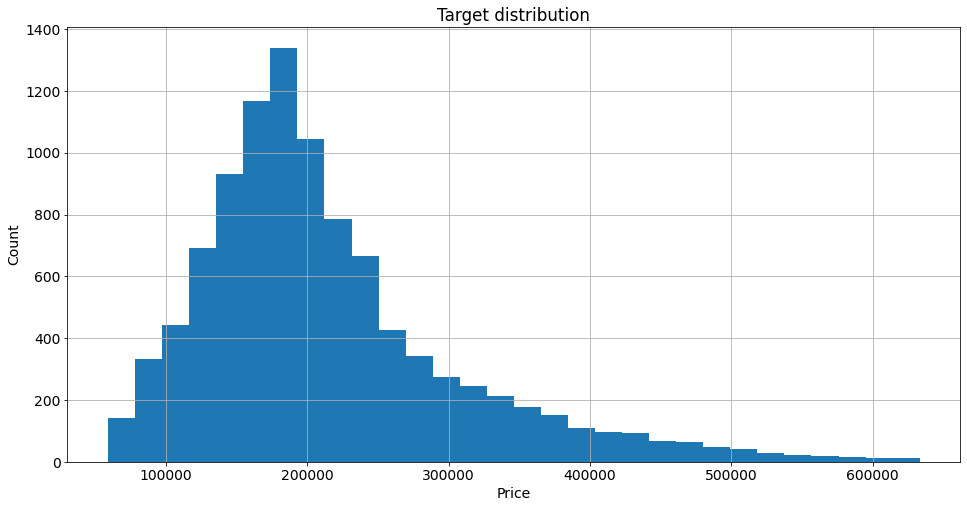

In [335]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [336]:
numerical_features = train_df.select_dtypes(include = [np.number])
print (f"count of numerical_features {numerical_features.shape[1]}")

numerical_features.columns

count of numerical_features 17


Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price'],
      dtype='object')

In [337]:
numerical_features.head(n=2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.08904,33,7976,5,NaN,0,11,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.00007,46,10309,1,240.0,1,16,300009.450063


In [338]:
# дискретные переменные
dicrete_feature = [
                   feature for feature in numerical_features
                   if len(train_df[feature].unique())<25 
]
print (f"Discrete Variables Count: {len(dicrete_feature)}")

Discrete Variables Count: 3


In [339]:
train_df[dicrete_feature].head(2)

,Rooms,Helthcare_2,Shops_1
0,2.0,0,11
1,3.0,1,16


In [340]:
# "непрерывные" переменные
continues_feature = [
                   feature for feature in numerical_features
                   if feature not in dicrete_feature]
                   
print (f"Continues Variables Count: {len(continues_feature )}")

Continues Variables Count: 14


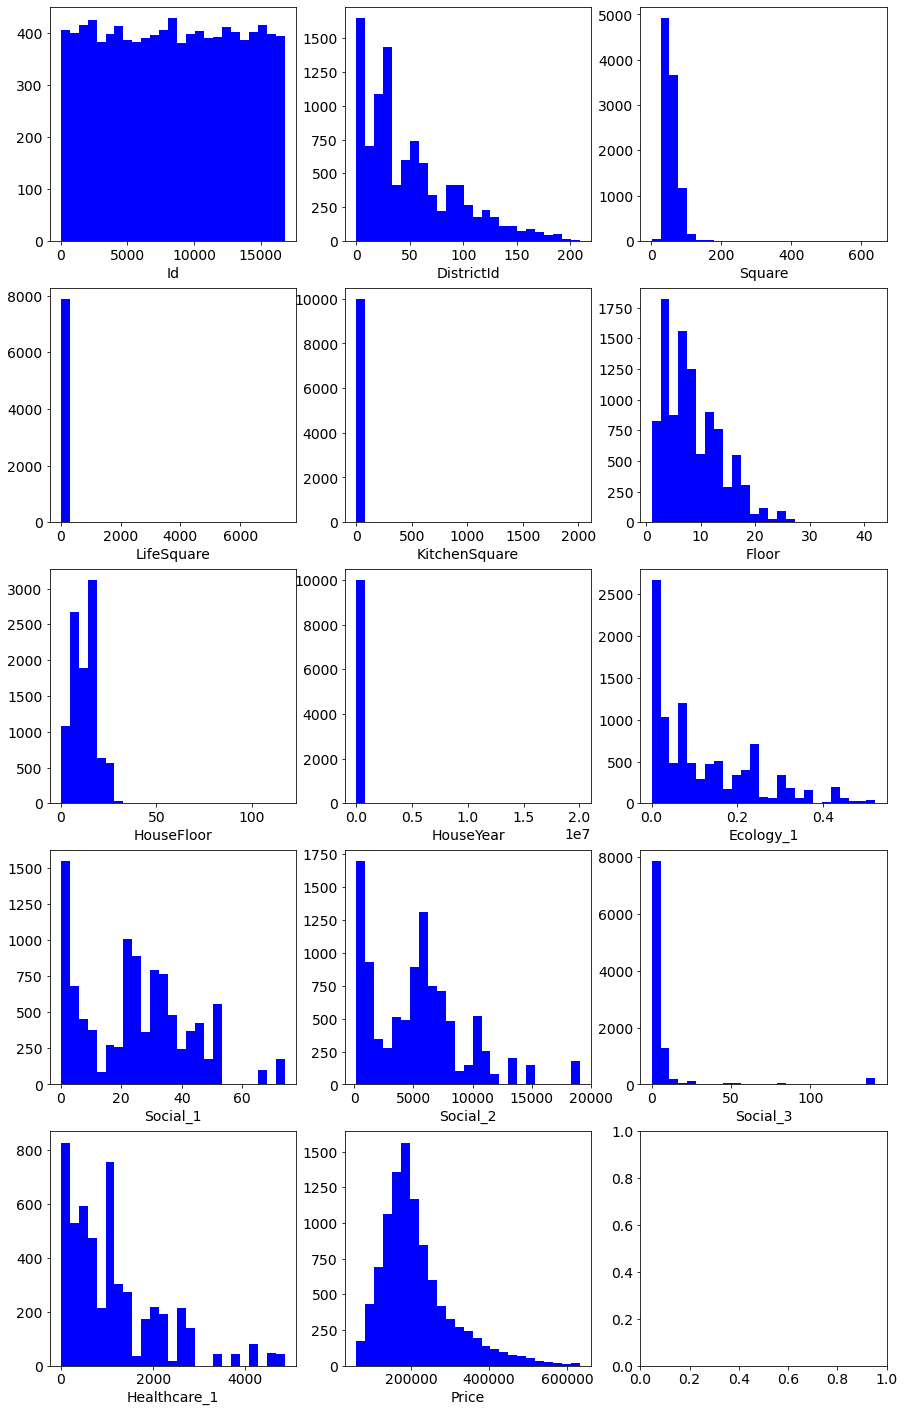

In [341]:
# построение гистогроамм непрерывных переменных
fig, axes = plt.subplots(5,3, figsize = (15,25))

for num, feature in enumerate(continues_feature):
  data = train_df[feature].copy()
  axes[num//3, num%3].hist(data, bins = 25, color = "blue")
  axes[num//3, num%3].set_xlabel(feature, fontsize = 14)


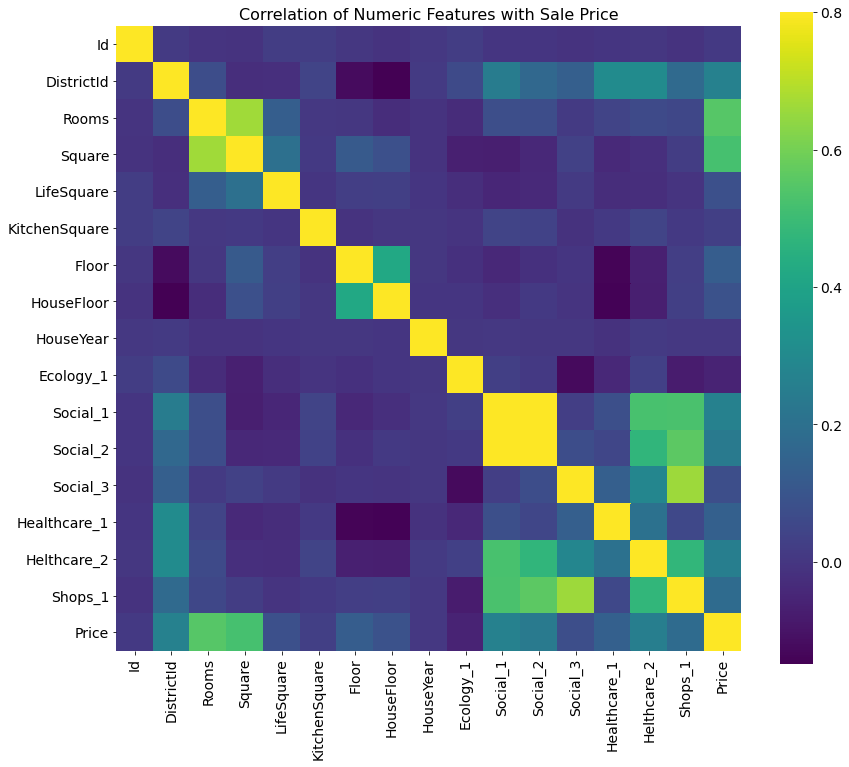

In [342]:
# корреляционная матрица численных переменных 
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(numerical_features.corr(), square = True, vmax=0.8, cmap="viridis")

### Обзор пропущенных значений

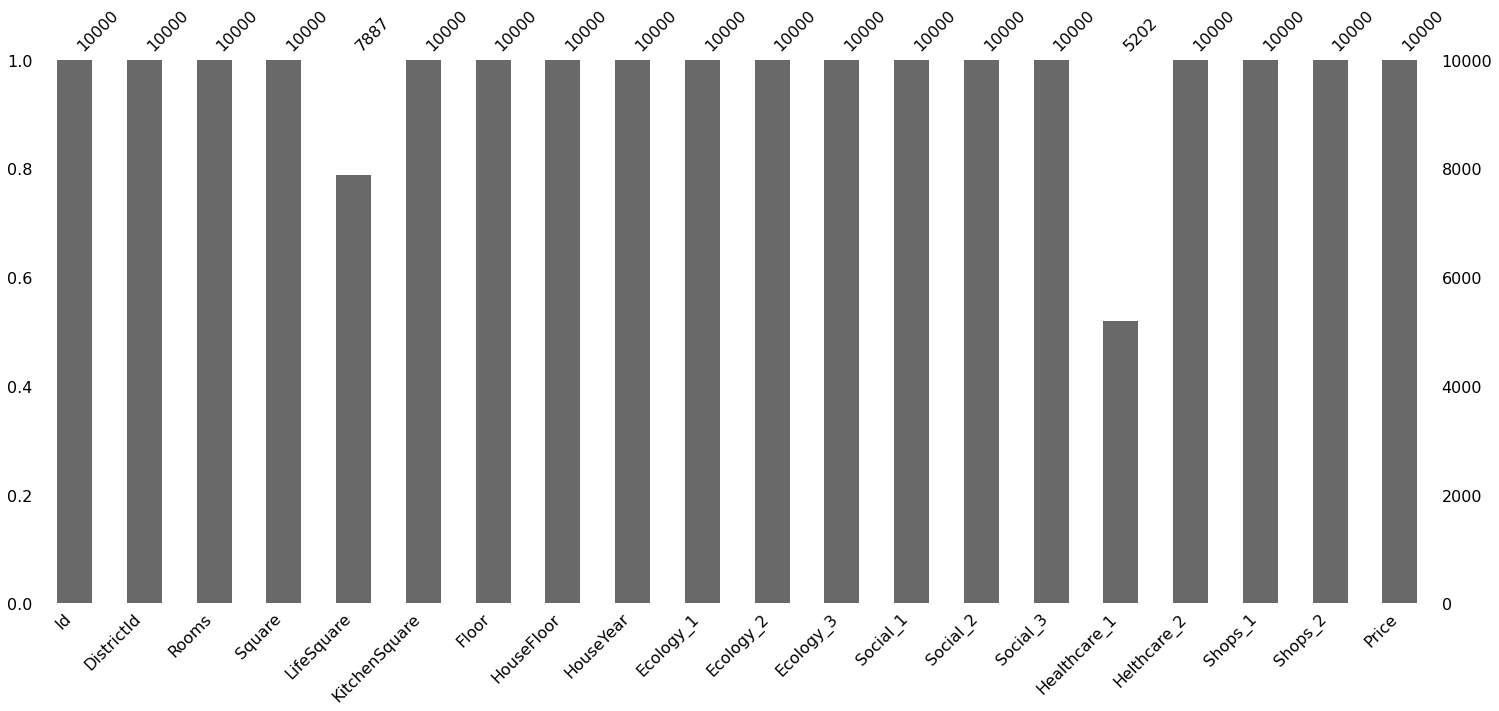

In [343]:
import missingno as msno
%matplotlib inline
msno.bar(train_df, labels = True)

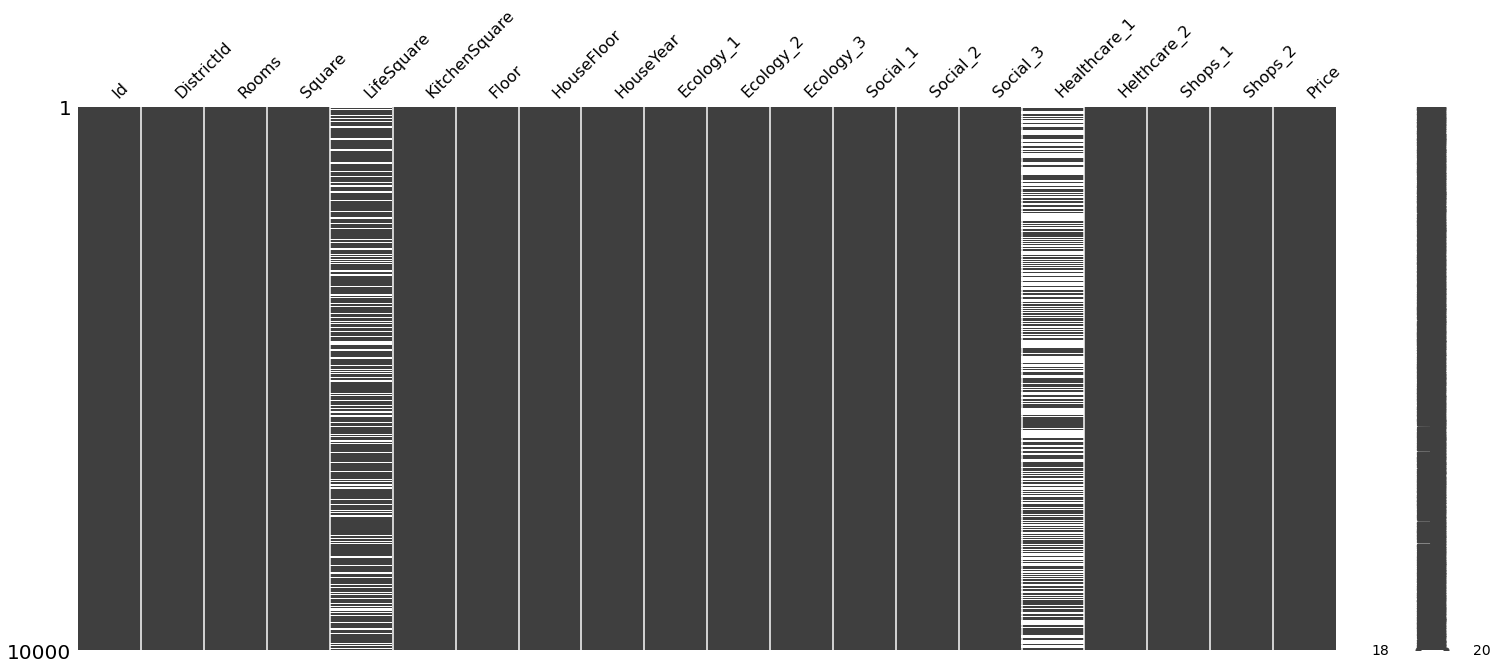

In [344]:
msno.matrix(train_df)

### Отработка выбросов

**Rooms**

In [345]:
# оценикаем выбросы в train_df по числу значений
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [346]:
# оценикаем выбросы в test_df по числу значений
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [347]:
# оценикаем медиану среди признака 'Rooms'
train_df['Rooms'].median()

2.0

In [348]:
# заменяем значения [0,5, 6, 10, 19] в выборке 'Rooms' на медиану по 'Rooms'
train_df.loc[train_df['Rooms'].isin([0,5, 6,  10, 19]), 'Rooms'] = train_df['Rooms'].median()

In [349]:
train_df['Rooms'].value_counts()

2.0    3910
1.0    3705
3.0    2235
4.0     150
Name: Rooms, dtype: int64

**Square, LifeSquare, KitchenSquare**

In [350]:
#  признаем выбросами все max, min, в "Square", "Square" и  "KitchenSquare" которые меньше 0.01 квантидя и больше 0.99 квантиля
train_df.loc[(train_df['Square'] > train_df['Square'].quantile(.99)) |
             (train_df['Square'] < train_df['Square'].quantile(.01))] = train_df['Square'].median()
train_df.loc[(train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.99)) |
             (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.01))] = train_df['LifeSquare'].median()
train_df.loc[(train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.99)) |
             (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.01))] = train_df['KitchenSquare'].median()

In [351]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [352]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

**HouseFloor, Floor**

In [353]:
train_df.loc[(train_df['HouseFloor'] == 0)|(train_df['HouseFloor'] > 60), 'HouseFloor'] = train_df['HouseFloor'].median()

In [354]:
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index
print(len(floor_outliers))

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

1484


**HouseYear**

In [355]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [356]:
train_df.loc[train_df['HouseYear'] < 1900, 'HouseYear'] = train_df['HouseYear'].median()

### Обработка пропусков

In [357]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2062
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4590
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

**LifeSquare**

In [358]:
train_df['LifeSquare'].median()

33.12965525585704

In [359]:
# считаем медиану разности общей площади и жилой площади  и  кухни (это неучтенная площадь)
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.121755180922465

In [360]:
# заполняем пропуски в жилой площади  с учетом "неучтенной площади"
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [361]:
train_df['LifeSquare'].median()

33.84357110468806

**Healthcare_1**

In [362]:
train_df['Healthcare_1'].head()

0       NaN
1     240.0
2     229.0
3    1084.0
4    2078.0
Name: Healthcare_1, dtype: float64

In [363]:
# заполняем "Healthcare_1" медианой так как не знаем его иединицы измерения
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

**Категориальные переменные**

In [364]:
# выделяем категориальные признаки (название колонок)
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Ecology_2', 'Ecology_3', 'Shops_2']

In [365]:
 #  Частоты потенциально возможных значений категориальных признаков
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Shops_2

B                    8853
A                     773
52.51330992401352     200
33.12965525585704     160
6.0                    14
Name: Shops_2, dtype: int64
****************************************************************************************************



In [366]:
train_df["Ecology_2"].describe()

count     10000
unique        5
top           B
freq       9534
Name: Ecology_2, dtype: object

In [367]:
train_df["Ecology_3"].describe()

count     10000
unique        5
top           B
freq       9354
Name: Ecology_3, dtype: object

In [368]:
train_df["Shops_2"].describe()

count     10000
unique        5
top           B
freq       8853
Name: Shops_2, dtype: object

In [369]:
train_df["Ecology_2"].unique()

array(['B', 52.51330992401352, 33.12965525585704, 'A', 6.0], dtype=object)

In [370]:
train_df["Ecology_3"].unique()

array(['B', 52.51330992401352, 33.12965525585704, 'A', 6.0], dtype=object)

In [371]:
train_df["Shops_2"].unique()

array(['B', 'A', 52.51330992401352, 33.12965525585704, 6.0], dtype=object)

In [372]:
train_df.loc[(train_df['Ecology_2'] != 'A')&(train_df['Ecology_2'] != 'B'), 'Ecology_2'] = 'B'
train_df.loc[(train_df['Ecology_3'] != 'A')&(train_df['Ecology_3'] != 'B'), 'Ecology_3'] = 'B'
train_df.loc[(train_df['Shops_2'] != 'A')&(train_df['Shops_2'] != 'B'), 'Shops_2'] = 'B'

In [373]:
# превращаем текстовые признаки в числовые
train_df['Ecology_2'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [374]:
train_df.select_dtypes(include='object').columns.tolist()

[]

In [375]:
train_df["DistrictId"].describe()

count    10000.000000
mean        50.252841
std         43.049611
min          0.000000
25%         21.000000
50%         37.000000
75%         74.000000
max        209.000000
Name: DistrictId, dtype: float64

In [376]:
train_df["DistrictId"].astype(int)

0        35
1        41
2        53
3        58
4        99
       ... 
9995     32
9996     18
9997     27
9998     75
9999    128
Name: DistrictId, Length: 10000, dtype: int64

In [377]:
train_df["DistrictId"].astype(int).describe()

count    10000.000000
mean        50.240500
std         43.049959
min          0.000000
25%         21.000000
50%         37.000000
75%         74.000000
max        209.000000
Name: DistrictId, dtype: float64

### Отбор признаков

In [378]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [379]:
feature_names = ['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1']

target_name = 'Price'

### Разбиение на train и test

In [380]:
X = train_df[feature_names]
y = train_df[target_name]

In [381]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение модели

**Обучение и оценка модели**

In [382]:
rf_model = RandomForestRegressor(max_depth=10, n_estimators=500, n_jobs=-1, random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

**Отложенная выборка**

Train R2:	0.869
Test R2:	0.758


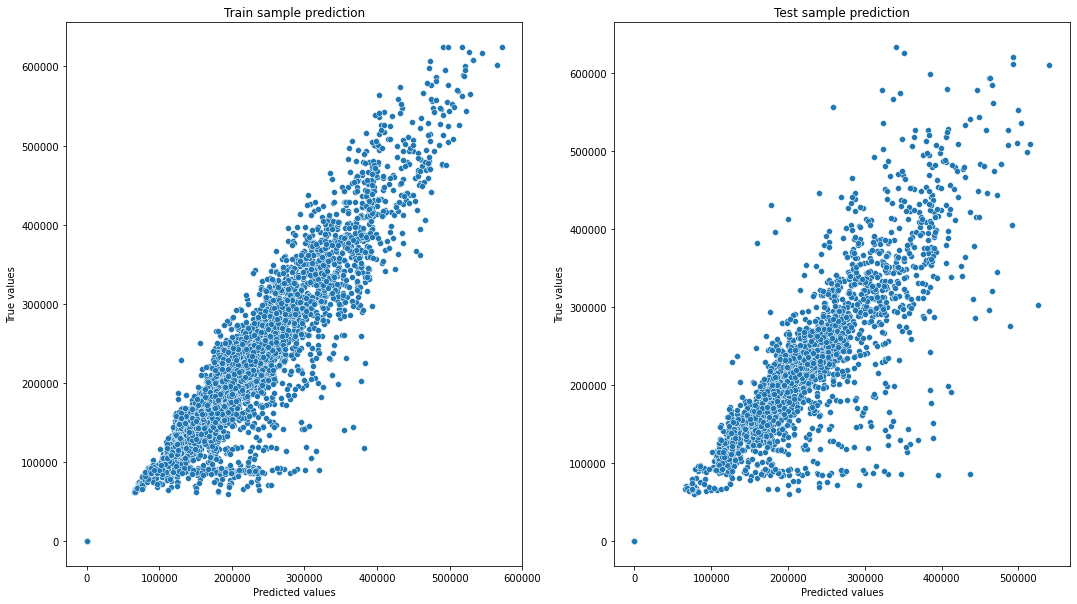

In [383]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [384]:
Xtest = test_df[feature_names]

**Важность признаков**

In [385]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.449976
8,Social_2,0.236761
7,Social_1,0.072670
9,Social_3,0.061770
6,Ecology_1,0.039720
0,Rooms,0.032440
10,Healthcare_1,0.024292
5,HouseYear,0.024016
2,LifeSquare,0.020964
3,KitchenSquare,0.020709


## Формирование файла с прогнозами

In [386]:
test_id = test_df["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = np.random.randint(0, 1e6, size=test_id.shape[0])
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv("./predictions_.csv", index=False)

In [387]:
pred_df = pd.read_csv("./predictions_.csv")
pred_df.head(n=2)

,Id,Price
0,725,700478
1,15856,603033
